# Analysis of EMMAA models and BEL corpus tests

In [1]:
import pandas as pd
import json
import jsonpickle
import matplotlib.pyplot as plt
%matplotlib inline
from indra.statements import Statement
from emmaa.model_tests import load_tests_from_s3
from emmaa.util import find_latest_s3_file, get_s3_client
from collections import defaultdict

INFO: [2019-11-27 15:29:04] indra.preassembler.grounding_mapper.adeft - Adeft will not be available for grounding disambiguation.
INFO: [2019-11-27 15:29:04] pybel.config - no configuration found, using default sqlite connection sqlite:////Users/dianakolusheva/.pybel/pybel_0.13.0_cache.db


In [2]:
tests = load_tests_from_s3('large_corpus_tests.pkl')
test_stmts = [test.stmt for test in tests]

INFO: [2019-11-27 15:29:05] emmaa.model_tests - Loading tests from tests/large_corpus_tests.pkl


In [3]:
models = ['aml', 'brca', 'luad', 'marm_model', 'paad', 'painmachine', 'prad', 'rasmachine', 'rasmodel', 'skcm']

## Applied tests

We start with a dataframe containing all test statements and their hashes.

In [4]:
all_tests = defaultdict(list)
for stmt in test_stmts:
    all_tests['Stmt_hash'].append(stmt.get_hash(refresh=True))
    all_tests['Stmt'].append(stmt)

In [5]:
df = pd.DataFrame(all_tests)
df = df.set_index('Stmt_hash')

Add columns showing whether the test was applied to every particular model.

In [6]:
def get_applied_tests_from_model(model_name):
    key = find_latest_s3_file('emmaa', f'results/{model_name}/results_', extension='.json')
    client = get_s3_client()
    obj = client.get_object(Bucket='emmaa', Key=key)
    json_results = json.loads(obj['Body'].read().decode('utf8'))
    test_stmts = [Statement._from_json(res['test_json']) for res in json_results[1:]]
    model_tests = defaultdict(list)
    for i, stmt in enumerate(test_stmts):
        model_tests['Stmt_hash'].append(stmt.get_hash(refresh=True))
        # Column to keep applied tests the rest will be willed with NaN at join
        model_tests[model_name].append(True)
    return pd.DataFrame(model_tests)

In [7]:
for model in models:
    model_df = get_applied_tests_from_model(model)
    df = df.join(model_df.set_index('Stmt_hash'))

In [8]:
len(df)

46534

In [9]:
df['not_nulls'] = 10 - df.isnull().sum(axis=1)

In [10]:
df.head()

,Stmt,aml,brca,luad,marm_model,paad,painmachine,prad,rasmachine,rasmodel,skcm,not_nulls
Stmt_hash,,,,,,,,,,,,
-14857780471372827,"Acetylation(BCL11B(), Histone_H3())",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
24364866633469333,"Acetylation(BCL11B(), Histone_H4())",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4247092595943875,"Acetylation(BRMS1(), RELA(), K, 310)",NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,1
-6015131980736417,"Acetylation(Ep300(catalytic), FOXO())",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
20956577376511618,"Acetylation(HDAC(catalytic), Histone_H2A())",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


We can find the tests applied to at least one model by filtering the rows to those having at least one not NaN value.

In [11]:
applied_df = df[df['not_nulls'] > 0]

In [12]:
len(applied_df)

7623

In [13]:
applied_df.head()

,Stmt,aml,brca,luad,marm_model,paad,painmachine,prad,rasmachine,rasmodel,skcm,not_nulls
Stmt_hash,,,,,,,,,,,,
4247092595943875,"Acetylation(BRMS1(), RELA(), K, 310)",NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,1
1389090038363257,"Acetylation(HDAC(catalytic), Histone_H2B())",NaN,True,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,2
-4690909190760849,"Acetylation(SIRT1(catalytic), FOXO(), K)",NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
-12903825413742202,"Acetylation(SIRT1(catalytic), Histone_H1())",NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,1
-33355740378841523,"Acetylation(SIRT1(catalytic), Histone_H3(), K, 9)",NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,1


For further analysis we can use just tests that have been applied to at least one model.

In [14]:
counts = applied_df.groupby('not_nulls').Stmt.count()

In [15]:
counts

not_nulls
1     5305
2     1267
3      471
4      272
5      130
6       73
7       34
8       67
10       4
Name: Stmt, dtype: int64

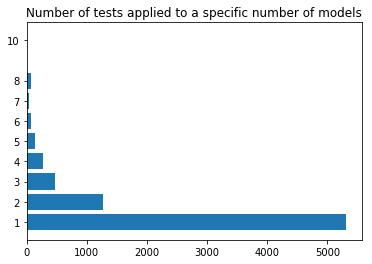

In [47]:
fig, ax = plt.subplots()
ax.barh(counts.index, counts)
ax.set_yticks(counts.index)
plt.title('Number of tests applied to a specific number of models')
plt.show()

In [17]:
applied_stmts = applied_df[['Stmt']].copy()

In [18]:
applied_stmts.head()

,Stmt
Stmt_hash,
4247092595943875,"Acetylation(BRMS1(), RELA(), K, 310)"
1389090038363257,"Acetylation(HDAC(catalytic), Histone_H2B())"
-4690909190760849,"Acetylation(SIRT1(catalytic), FOXO(), K)"
-12903825413742202,"Acetylation(SIRT1(catalytic), Histone_H1())"
-33355740378841523,"Acetylation(SIRT1(catalytic), Histone_H3(), K, 9)"


## Tests passed for each model and model type

In [19]:
def get_tests_and_results_from_model(model_name, model_type):
    key = find_latest_s3_file('emmaa', f'results/{model_name}/results_', extension='.json')
    client = get_s3_client()
    obj = client.get_object(Bucket='emmaa', Key=key)
    json_results = json.loads(obj['Body'].read().decode('utf8'))
    test_stmts = [Statement._from_json(res['test_json']) for res in json_results[1:]]
    unpickler = jsonpickle.unpickler.Unpickler()
    test_results = [unpickler.restore(result[model_type]['result_json'])
                    for result in json_results[1:]]
    model_results = defaultdict(list)
    for i, stmt in enumerate(test_stmts):
        model_results['Stmt_hash'].append(stmt.get_hash(refresh=True))
        model_results[model_name].append(test_results[i].path_found)
    return pd.DataFrame(model_results)

In [20]:
def get_df_for_model_type(model_type):
    df = applied_stmts.copy()
    for model in models:
        model_df = get_tests_and_results_from_model(model, model_type)
        df = df.join(model_df.set_index('Stmt_hash'))
    return df

For all model types the tests are sorted by number of mofe

### PySB

In [21]:
pysb_df = get_df_for_model_type('pysb')

In [23]:
pysb_df['passed'] = pysb_df[models].sum(axis=1).astype('int64')

In [24]:
pysb_df['applied'] = 10 - pysb_df.isnull().sum(axis=1)

In [26]:
pysb_df = pysb_df.sort_values(['applied', 'passed'], ascending=[True, True]).reset_index()

In [34]:
pysb_df.head()

,Stmt_hash,Stmt,aml,brca,luad,marm_model,paad,painmachine,prad,rasmachine,rasmodel,skcm,passed,applied
0,4247092595943875,"Acetylation(BRMS1(), RELA(), K, 310)",NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,0,1
1,-4690909190760849,"Acetylation(SIRT1(catalytic), FOXO(), K)",NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
2,-12903825413742202,"Acetylation(SIRT1(catalytic), Histone_H1())",NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,0,1
3,-33355740378841523,"Acetylation(SIRT1(catalytic), Histone_H3(), K, 9)",NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,0,1
4,-33252994353019109,"Activation(ABL1(kinase), CDK5(), kinase)",NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,0,1


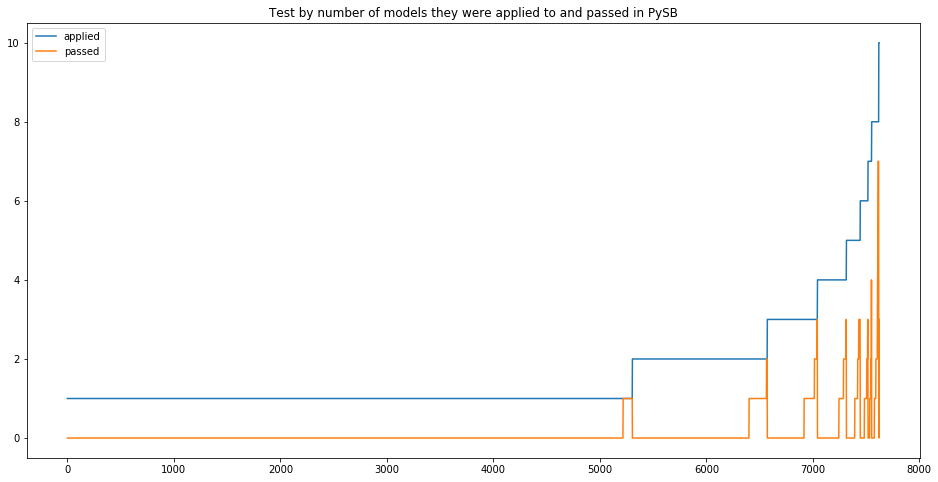

In [36]:
plt.figure(figsize=(16, 8))
plt.plot('applied', data=pysb_df)
plt.plot('passed', data=pysb_df)
plt.title('Test by number of models they were applied to and passed in PySB')
plt.legend()

### PyBEL

In [29]:
pybel_df = get_df_for_model_type('pybel')

In [31]:
pybel_df['passed'] = pybel_df[models].sum(axis=1).astype('int64')
pybel_df['applied'] = 10 - pybel_df.isnull().sum(axis=1)
pybel_df = pybel_df.sort_values(['applied', 'passed'], ascending=[True, True]).reset_index()

In [33]:
pybel_df.head()

,Stmt_hash,Stmt,aml,brca,luad,marm_model,paad,painmachine,prad,rasmachine,rasmodel,skcm,passed,applied
0,4247092595943875,"Acetylation(BRMS1(), RELA(), K, 310)",NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,0,1
1,-4690909190760849,"Acetylation(SIRT1(catalytic), FOXO(), K)",NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
2,-12903825413742202,"Acetylation(SIRT1(catalytic), Histone_H1())",NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,0,1
3,-33355740378841523,"Acetylation(SIRT1(catalytic), Histone_H3(), K, 9)",NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,0,1
4,-33252994353019109,"Activation(ABL1(kinase), CDK5(), kinase)",NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,0,1


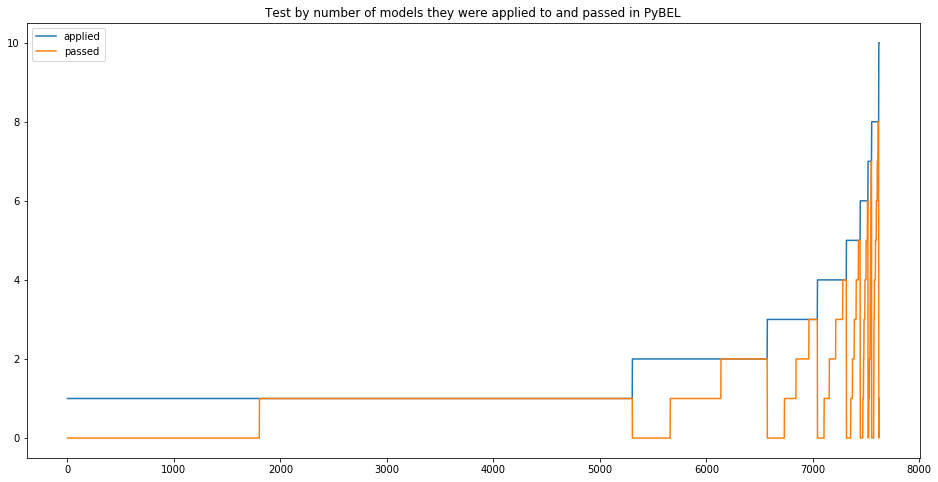

In [35]:
plt.figure(figsize=(16, 8))
plt.plot('applied', data=pybel_df)
plt.plot('passed', data=pybel_df)
plt.title('Test by number of models they were applied to and passed in PyBEL')
plt.legend()

### Signed Graph

In [37]:
signed_df = get_df_for_model_type('signed_graph')

In [38]:
signed_df['passed'] = signed_df[models].sum(axis=1).astype('int64')
signed_df['applied'] = 10 - signed_df.isnull().sum(axis=1)
signed_df = signed_df.sort_values(['applied', 'passed'], ascending=[True, True]).reset_index()

In [39]:
signed_df.head()

,Stmt_hash,Stmt,aml,brca,luad,marm_model,paad,painmachine,prad,rasmachine,rasmodel,skcm,passed,applied
0,4247092595943875,"Acetylation(BRMS1(), RELA(), K, 310)",NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,0,1
1,-4690909190760849,"Acetylation(SIRT1(catalytic), FOXO(), K)",NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
2,-12903825413742202,"Acetylation(SIRT1(catalytic), Histone_H1())",NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,0,1
3,-33355740378841523,"Acetylation(SIRT1(catalytic), Histone_H3(), K, 9)",NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,0,1
4,-33252994353019109,"Activation(ABL1(kinase), CDK5(), kinase)",NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,0,1


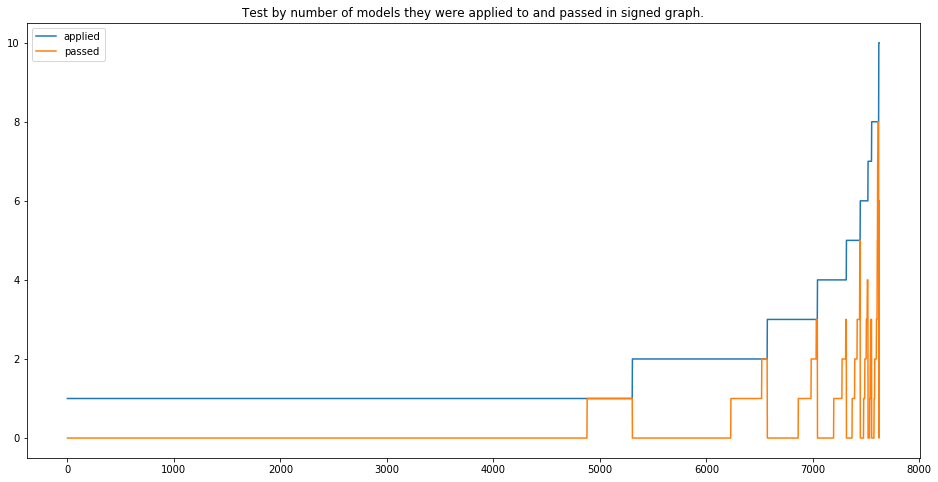

In [41]:
plt.figure(figsize=(16, 8))
plt.plot('applied', data=signed_df)
plt.plot('passed', data=signed_df)
plt.title('Test by number of models they were applied to and passed in signed graph.')
plt.legend()

### Unsigned Graph

In [42]:
unsigned_df = get_df_for_model_type('unsigned_graph')

In [43]:
unsigned_df['passed'] = unsigned_df[models].sum(axis=1).astype('int64')
unsigned_df['applied'] = 10 - unsigned_df.isnull().sum(axis=1)
unsigned_df = unsigned_df.sort_values(['applied', 'passed'], ascending=[True, True]).reset_index()

In [44]:
unsigned_df.head()

,Stmt_hash,Stmt,aml,brca,luad,marm_model,paad,painmachine,prad,rasmachine,rasmodel,skcm,passed,applied
0,-33252994353019109,"Activation(ABL1(kinase), CDK5(), kinase)",NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,0,1
1,30705551399043617,"Activation(ACVR2A(kinase), SMAD2(), transcript...",NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,0,1
2,-2827220569010000,"Activation(AGER(catalytic), inflammatory respo...",NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,0,1
3,-24907111438665284,"Activation(BLVRA(kinase), PRKCB(), kinase)",NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,0,1
4,-32681309917118039,"Activation(BMP1(), cell differentiation())",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0,1


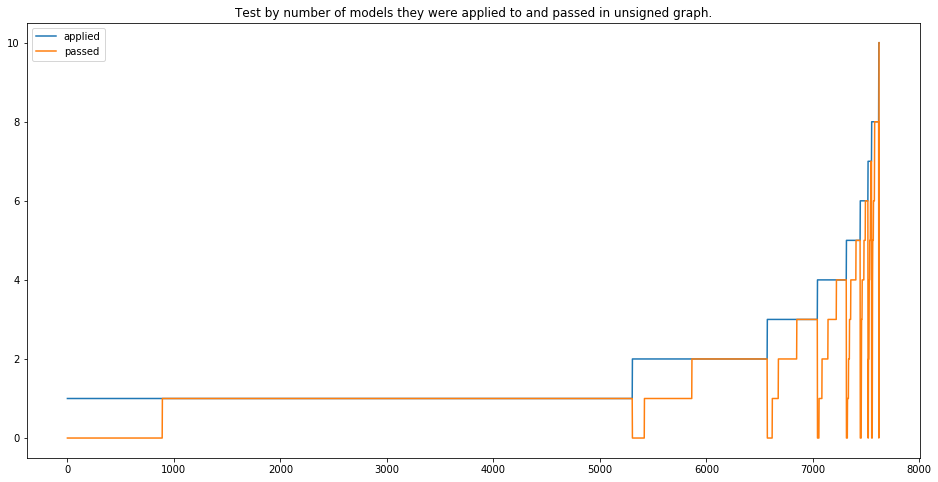

In [45]:
plt.figure(figsize=(16, 8))
plt.plot('applied', data=unsigned_df)
plt.plot('passed', data=unsigned_df)
plt.title('Test by number of models they were applied to and passed in unsigned graph.')
plt.legend()